In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import csv
from time import time
from sklearn.pipeline import Pipeline
from matplotlib import ticker, cm
# from scipy.sparse import csr_matrix

from swimnetworks import (Dense, Linear)
np.set_printoptions(threshold=np.inf)

In [11]:
def tanh_x(x):
    """First derivative of tanh.
    """
    x = np.clip(x, -10, 10)
    return 1-np.tanh(x)**2
    # return 1/np.cosh(x)**2

def tanh_xx(x):
    x = np.clip(x, -10, 10)
    return -2*np.tanh(x)*(1-np.tanh(x)**2)


Text(0.5, 1.0, 'Step function')

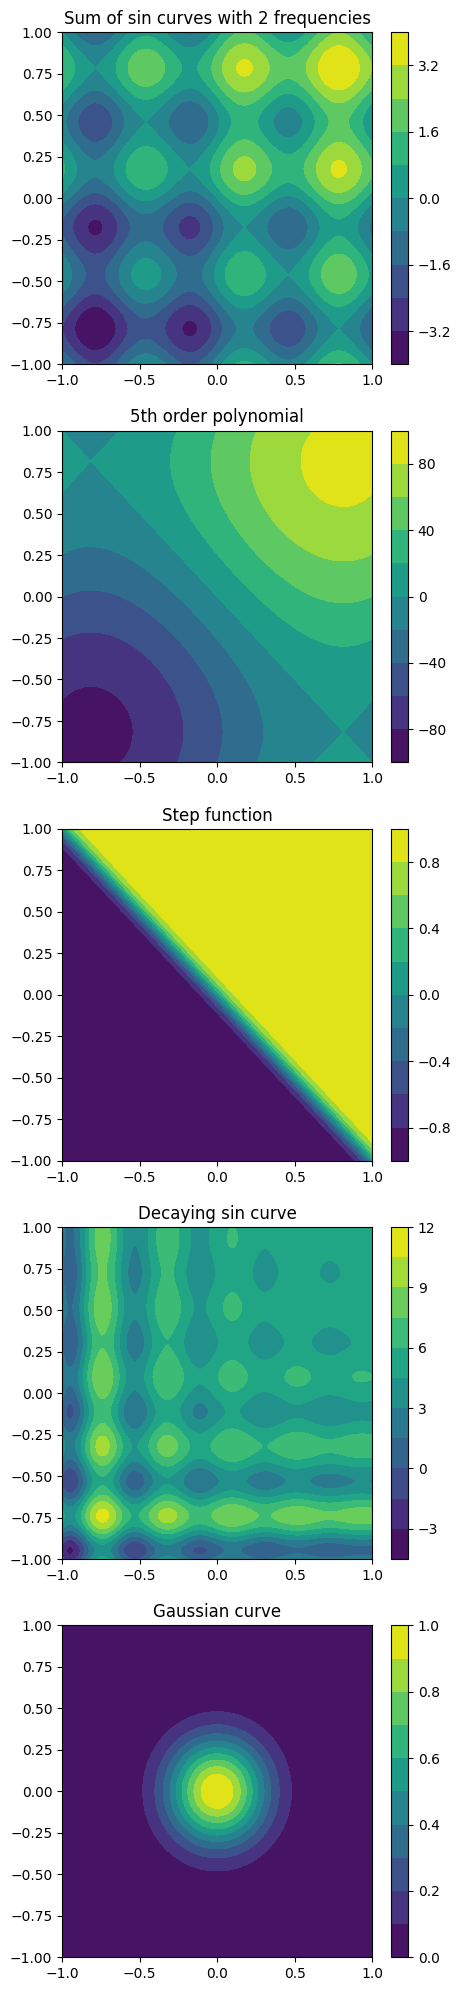

In [12]:
# setup the problem ODE
def u_laplacian(x):
    return np.zeros((x.shape[0],1))

def u_true_sin_2_freq(x):
    return np.sin(2*x[:,0]) + np.sin(10*x[:,0]) + np.sin(2*x[:,1]) + np.sin(10*x[:,1])

def u_true_laplacian_sin_2_freq(x):
    return -4*np.sin(2*x[:,0]) - 100*np.sin(10*x[:,0]) - 4*np.sin(2*x[:,1]) - 100*np.sin(10*x[:,1])

def u_true_sum_sin(x):
    return np.sin(2*x[:,0]) + np.sin(2*x[:,1])

def u_true_laplacian_sum_sin(x):
    return -4*np.sin(2*x[:,0]) -4*np.sin(2*x[:,1])

def u_true_laplacian_sin_2_freq(x):
    return -4*np.sin(2*x[:,0]) - 100*np.sin(10*x[:,0]) - 4*np.sin(2*x[:,1]) - 100*np.sin(10*x[:,1])

def u_true_polynomial(x):
    return 4*(x[:,0]**5 + x[:,1]**5) - 45*(x[:,0]**3 + x[:,1]**3) + 81*(x[:,0] + x[:,1])

def u_true_laplacian_polynomial(x):
    return 80*(x[:,0]**3 + x[:,1]**3) - 270*(x[:,0] + x[:,1])

def u_true_step_1(x):
    return np.tanh(10*x[:,0]+10*x[:,1])

def u_true_laplacian_step_1(x):
    return -400*np.tanh(10*(x[:,0]+x[:,1]))*(1-np.tanh(10*(x[:,0]+x[:,1]))**2)

def u_true_step(x):
    return np.tanh(10*x[:,0])

def u_true_laplacian_step(x):
    return -200*np.tanh(10*(x[:,0]))*(1-np.tanh(10*(x[:,0]))**2)

def u_true_decaying_sin(x):
    return np.sin(15*x[:,0])*np.exp(-1.5*x[:,0]) + np.sin(15*x[:,1])*np.exp(-1.5*x[:,1]) + 5

def u_true_laplacian_decaying_sin(x):
    return -np.exp(-1.5*x[:,0])*(222.75*np.sin(15*x[:,0]) + 45*np.cos(15*x[:,0])) - np.exp(-1.5*x[:,1])*(222.75*np.sin(15*x[:,1]) + 45*np.cos(15*x[:,1]))

def u_true_gaussian(x):
    return np.exp(-(x[:,0]**2/0.1 + x[:,1]**2/0.1))

def u_true_laplacian_gaussian(x):
    return (400*x[:,0]**2-20)*np.exp(-10*(x[:,0]**2 + x[:,1]**2)) + (400*x[:,1]**2-20)*np.exp(-10*(x[:,0]**2 + x[:,1]**2))

step = u_true_step_1
step_laplacian = u_true_step_1

x_plot = np.linspace(-1, 1, 150)
y_plot = np.linspace(-1, 1, 150)

x_p, y_p = np.meshgrid(x_plot, y_plot)
x_input = np.column_stack([x_p.reshape(-1,1), y_p.reshape(-1,1)])

fig, ax = plt.subplots(5, 1, figsize=(5, 25))

contour1 = ax[0].contourf(x_p, y_p, u_true_sin_2_freq(x_input).reshape(150,150), levels=10, cmap='viridis')
contour2 = ax[1].contourf(x_p, y_p, u_true_polynomial(x_input).reshape(150,150), levels=10, cmap='viridis')
contour3 = ax[2].contourf(x_p, y_p, step(x_input).reshape(150,150), levels=10, cmap='viridis')
contour4 = ax[3].contourf(x_p, y_p, u_true_decaying_sin(x_input).reshape(150,150), levels=10, cmap='viridis')
contour5 = ax[4].contourf(x_p, y_p, u_true_gaussian(x_input).reshape(150,150), levels=10, cmap='viridis')


colorbar = plt.colorbar(contour1, ax=ax[0])
colorbar = plt.colorbar(contour2, ax=ax[1])
colorbar = plt.colorbar(contour3, ax=ax[2])
colorbar = plt.colorbar(contour4, ax=ax[3])
colorbar = plt.colorbar(contour5, ax=ax[4])

ax[3].set_title('Decaying sin curve')
ax[0].set_title('Sum of sin curves with 2 frequencies')
ax[4].set_title('Gaussian curve')
ax[1].set_title('5th order polynomial')
ax[2].set_title('Step function')



In [13]:
def generate_points(domain, subdomains, num_points_subdomain, num_pts_boundary, gridDD, Normalizing_input, plot_points, random_state, nx=1, ny=1):
    rng = np.random.default_rng(random_state)

    domain_vertex = np.array(domain["vertices"])
    # {"type": "circle", "center": (0, 0), "radius": np.pi}

    if gridDD:
    
        x_sep=np.linspace(domain_vertex[0][0], domain_vertex[2][0], nx+1)
        y_sep=np.linspace(domain_vertex[0][1], domain_vertex[2][1], ny+1)
        for j in range(ny):
            for i in range(nx):
                dict = {}
                vertex_list = [(x_sep[i], y_sep[j]), (x_sep[i], y_sep[j+1]), (x_sep[i+1], y_sep[j+1]), (x_sep[i+1], y_sep[j])]
                dict = {"type": "rectangle", "vertices": vertex_list}
                subdomains.append(dict)
        
        x_center = []
        x_radius = []
        y_center = []
        y_radius = []

        if Normalizing_input:
            for i in range(len(subdomains)):
                subdomain_vertices = np.array(subdomains[i]["vertices"])

                x_center.append((subdomain_vertices[2][0] + subdomain_vertices[0][0])/2)
                y_center.append((subdomain_vertices[2][1] + subdomain_vertices[0][1])/2)
                x_radius.append((subdomain_vertices[2][0] - subdomain_vertices[0][0])/2)
                y_radius.append((subdomain_vertices[2][1] - subdomain_vertices[0][1])/2)

            x_center = np.array(x_center)
            y_center = np.array(y_center)
            x_radius = np.array(x_radius)
            y_radius = np.array(y_radius)
        else:
            for i in range(len(subdomains)):
                subdomain_vertices = np.array(subdomains[i]["vertices"])

                x_center.append(0)
                y_center.append(0)
                x_radius.append(1)
                y_radius.append(1)

            x_center = np.array(x_center)
            y_center = np.array(y_center)
            x_radius = np.array(x_radius)
            y_radius = np.array(y_radius)


    else:
        ## Add subdomains by specifying type and geometry information
        ## Currently shared boundary subdomains is only implemented for type:rectangle subdomains
        # subdomains = [
        #     # {"type": "rectangle", "vertices": [(-np.pi, -np.pi), (-np.pi, np.pi), (np.pi, np.pi), (np.pi, -np.pi)]}
        #     {"type": "rectangle", "vertices": [(-np.pi, -np.pi), (-np.pi, -1.5), (-1.5, -1.5), (-1.5, -np.pi)]},
        #     {"type": "rectangle", "vertices": [(-1.5, -np.pi), (-1.5, -1.5), (1.5, -1.5), (1.5, -np.pi)]},
        #     {"type": "rectangle", "vertices": [(1.5, -np.pi), (1.5, -1.5), (np.pi, -1.5), (np.pi, -np.pi)]},
        #     {"type": "rectangle", "vertices": [(-np.pi, -1.5), (-np.pi, 1.5), (-1.5, 1.5), (-1.5, -1.5)]},  
        #     {"type": "rectangle", "vertices": [(-1.5, -1.5), (-1.5, 1.5), (1.5, 1.5), (1.5, -1.5)]},
        #     {"type": "rectangle", "vertices": [(1.5, -1.5), (1.5, 1.5), (np.pi, 1.5), (np.pi, -1.5)]},
        #     {"type": "rectangle", "vertices": [(-np.pi, 1.5), (-np.pi, np.pi), (-1.5, np.pi), (-1.5, 1.5)]},
        #     {"type": "rectangle", "vertices": [(-1.5, 1.5), (-1.5, np.pi), (1.5, np.pi), (1.5, 1.5)]},
        #     {"type": "rectangle", "vertices": [(1.5, 1.5), (1.5, np.pi), (np.pi, np.pi), (np.pi, 1.5)]},
        #     # {"type": "domain", "vertices": [(-np.pi, -np.pi), (-np.pi, np.pi), (np.pi, np.pi), (np.pi, -np.pi)]}
        #     # {"type": "circle", "center": (0, 0), "radius": 0.5},
        #     # {"type": "circle", "center": (1.5, 1.5), "radius": 1}
        # ]

        # subdomains = [
        #     # {"type": "rectangle", "vertices": [(-np.pi, -np.pi), (-np.pi, np.pi), (np.pi, np.pi), (np.pi, -np.pi)]}
        #     {"type": "rectangle", "vertices": [(-np.pi, -np.pi), (-np.pi, -1.5), (-1.5, -1.5), (-1.5, -np.pi)]},
        #     {"type": "rectangle", "vertices": [(-1.5, -np.pi), (-1.5, -1.5), (0, -1.5), (0, -np.pi)]},
        #     {"type": "rectangle", "vertices": [(0, -np.pi), (0, -1.5), (1.5, -1.5), (1.5, -np.pi)]},
        #     {"type": "rectangle", "vertices": [(1.5, -np.pi), (1.5, -1.5), (np.pi, -1.5), (np.pi, -np.pi)]},
        #     {"type": "rectangle", "vertices": [(-np.pi, -1.5), (-np.pi, 1.5), (-1.5, 1.5), (-1.5, -1.5)]},  
        #     {"type": "rectangle", "vertices": [(-1.5, -1.5), (-1.5, 1.5), (1.5, 1.5), (1.5, -1.5)]},
        #     {"type": "rectangle", "vertices": [(1.5, -1.5), (1.5, 1.5), (np.pi, 1.5), (np.pi, -1.5)]},
        #     {"type": "rectangle", "vertices": [(-np.pi, 1.5), (-np.pi, np.pi), (-1.5, np.pi), (-1.5, 1.5)]},
        #     {"type": "rectangle", "vertices": [(-1.5, 1.5), (-1.5, np.pi), (1.5, np.pi), (1.5, 1.5)]},
        #     {"type": "rectangle", "vertices": [(1.5, 1.5), (1.5, np.pi), (np.pi, np.pi), (np.pi, 1.5)]},
        #     # {"type": "domain", "vertices": [(-np.pi, -np.pi), (-np.pi, np.pi), (np.pi, np.pi), (np.pi, -np.pi)]}
        #     # {"type": "circle", "center": (0, 0), "radius": 0.5},
        #     # {"type": "circle", "center": (1.5, 1.5), "radius": 1}
        # ]

        # subdomains = [
        #     # {"type": "rectangle", "vertices": [(-np.pi, -np.pi), (-np.pi, np.pi), (np.pi, np.pi), (np.pi, -np.pi)]}
        #     {"type": "rectangle", "vertices": [(-np.pi, -np.pi), (-np.pi, -1.5), (-1.5, -1.5), (-1.5, -np.pi)]},
        #     {"type": "rectangle", "vertices": [(-1.5, -np.pi), (-1.5, -1.5), (1.5, -1.5), (1.5, -np.pi)]},
        #     {"type": "rectangle", "vertices": [(1.5, -np.pi), (1.5, -1.5), (np.pi, -1.5), (np.pi, -np.pi)]},
        #     {"type": "rectangle", "vertices": [(-np.pi, -1.5), (-np.pi, 1.5), (0, 1.5), (0, -1.5)]},  
        #     {"type": "rectangle", "vertices": [(0, -1.5), (0, 1.5), (np.pi, 1.5), (np.pi, -1.5)]},
        #     {"type": "rectangle", "vertices": [(-np.pi, 1.5), (-np.pi, np.pi), (-1.5, np.pi), (-1.5, 1.5)]},
        #     {"type": "rectangle", "vertices": [(-1.5, 1.5), (-1.5, np.pi), (1.5, np.pi), (1.5, 1.5)]},
        #     {"type": "rectangle", "vertices": [(1.5, 1.5), (1.5, np.pi), (np.pi, np.pi), (np.pi, 1.5)]},
        #     # {"type": "domain", "vertices": [(-np.pi, -np.pi), (-np.pi, np.pi), (np.pi, np.pi), (np.pi, -np.pi)]}
        #     # {"type": "circle", "center": (0, 0), "radius": 0.5},
        #     # {"type": "circle", "center": (1.5, 1.5), "radius": 1}
        # ]

        # subdomains = [
        #     # {"type": "rectangle", "vertices": [(-np.pi, -np.pi), (-np.pi, np.pi), (np.pi, np.pi), (np.pi, -np.pi)]}
        #     {"type": "rectangle", "vertices": [(-np.pi, -np.pi), (-np.pi, 1.5), (-1.5, 1.5), (-1.5, -np.pi)]},
        #     {"type": "rectangle", "vertices": [(-1.5, -np.pi), (-1.5, -1.5), (np.pi, -1.5), (np.pi, -np.pi)]},
        #     {"type": "rectangle", "vertices": [(-1.5, -1.5), (-1.5, 1.5), (1.5, 1.5), (1.5, -1.5)]},
        #     {"type": "rectangle", "vertices": [(1.5, -1.5), (1.5, np.pi), (np.pi, np.pi), (np.pi, -1.5)]},
        #     {"type": "rectangle", "vertices": [(-np.pi, 1.5), (-np.pi, np.pi), (1.5, np.pi), (1.5, 1.5)]},  
            
        #     # {"type": "domain", "vertices": [(-np.pi, -np.pi), (-np.pi, np.pi), (np.pi, np.pi), (np.pi, -np.pi)]}
        #     # {"type": "circle", "center": (0, 0), "radius": 0.5},
        #     # {"type": "circle", "center": (1.5, 1.5), "radius": 1}
        # ]

        x_center = []
        x_radius = []
        y_center = []
        y_radius = []
        for i in range(len(subdomains)):
            subdomain_vertices = np.array(subdomains[i]["vertices"])

            x_center.append(0)
            y_center.append(0)
            x_radius.append(1)
            y_radius.append(1)

        x_center = np.array(x_center)
        y_center = np.array(y_center)
        x_radius = np.array(x_radius)
        y_radius = np.array(y_radius)

        # subdomains = [
        #     # {"type": "rectangle", "vertices": [(-np.pi, -np.pi), (-np.pi, np.pi), (np.pi, np.pi), (np.pi, -np.pi)]}
        #     # {"type": "rectangle", "vertices": [(-1.5, -np.pi), (-1.5, -1.5), (np.pi, -1.5), (np.pi, -np.pi)]},
        #     {"type": "rectangle", "vertices": [(-1.5, -1.5), (-1.5, 1.5), (1.5, 1.5), (1.5, -1.5)]},
            
        #     {"type": "domain", "vertices": [(-np.pi, -np.pi), (-np.pi, np.pi), (np.pi, np.pi), (np.pi, -np.pi)]}
        #     # {"type": "circle", "center": (0, 0), "radius": 0.5},
        #     # {"type": "circle", "center": (1.5, 1.5), "radius": 1}
        # ]

    def is_inside_subdomain(point, subdomain):
        """Helper function to check whether a coordinate is inside a subdomain."""

        if subdomain["type"] == "rectangle":
            vertices = np.array(subdomain["vertices"])
            return np.all(vertices[0] < point) and np.all(point < vertices[2])
        elif subdomain["type"] == "circle":
            center = np.array(subdomain["center"])
            radius = subdomain["radius"]
            return np.linalg.norm(point - center) < radius
        else:
            return False

    def generate_points_domain(domain, subdomains, num_points):
        """Samples points inside the domain but outside all the subdomains."""

        points = []
        if domain["type"] == "rectangle":
            while len(points) < num_points:
                point = rng.uniform(
                    low=(domain["vertices"][0]),
                    high=(domain["vertices"][2]),
                )
                if not any(is_inside_subdomain(point, subdomain) for subdomain in subdomains):
                    points.append(point)

        elif domain["type"] == "circle":
            center = np.array(domain["center"])
            radius = domain["radius"]
            while len(points) < num_points:
                r = np.sqrt(rng.uniform(0, 1, size=num_points)) * radius
                theta = rng.uniform(0, 2 * np.pi, size=num_points)
                point = center + np.column_stack((r * np.cos(theta), r * np.sin(theta)))
                if not any(is_inside_subdomain(point, subdomain) for subdomain in subdomains):
                    points.append(point)

        return points

    def generate_points_subdomain(subdomain, num_points):
        """Generate points inside the subdomain based on the geometry information of the subdomain."""

        if subdomain["type"] == "rectangle":
            vertices = np.array(subdomain["vertices"])
            min_x, min_y = np.min(vertices, axis=0)
            max_x, max_y = np.max(vertices, axis=0)
            points = rng.uniform(low=(min_x, min_y), high=(max_x, max_y), size=(num_points, 2))
        elif subdomain["type"] == "circle":
            center = np.array(subdomain["center"])
            radius = subdomain["radius"]
            r = np.sqrt(rng.uniform(0, 1, size=num_points)) * radius
            theta = rng.uniform(0, 2 * np.pi, size=num_points)
            points = center + np.column_stack((r * np.cos(theta), r * np.sin(theta)))
        else:
            points = np.array([])  
        return points

    def generate_boundary_points(subdomain, num_points):
        """Generate points on the boundary of the subdomain. (Currently used to sample points from the boundary of the overall domain)"""

        boundary_points = []
        if subdomain["type"] == "rectangle":
            vertices = np.array(subdomain["vertices"])
            for i in range(len(vertices)):
                p1 = vertices[i]
                p2 = vertices[(i + 1) % len(vertices)]
                boundary_points.extend(
                    [p1 + t * (p2 - p1) for t in np.linspace(0, 1, int(num_points/4)+2)][1:-1]
                    # [p1 + t * (p2 - p1) for t in np.linspace(0, 1, int(num_points/4), endpoint=False)]
                )
            boundary_points = np.array(boundary_points)
        elif subdomain["type"] == "circle":
            theta = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
            boundary_points = subdomain["center"] + subdomain["radius"] * np.column_stack((np.cos(theta), np.sin(theta)))
        else:
            boundary_points = []  
        return boundary_points

    def find_neighboring_subdomains(subdomain):
        """Function to sample shared points between subdomains and generate a list containing neighboring information."""

        shared_points_subdomain = {}
        neighboring_subdomains = {}
        shared_points_perunitlength = 93  #### For future sample shared points based on the size of the shared boundary
        for i, sub1 in enumerate(subdomain):
            neighbors = []
            shared_points = []
            vertices1 = np.array(sub1["vertices"])
            for j, sub2 in enumerate(subdomain):
                if i != j: 
                    vertices2 = np.array(sub2["vertices"])
                    x_touching = (min(vertices1[2][0], vertices2[2][0]) == max(vertices1[0][0], vertices2[0][0])) and (min(vertices1[2][1], vertices2[2][1]) > max(vertices1[0][1], vertices2[0][1]))
                    y_shared_x_touching = [max(vertices1[0][1], vertices2[0][1]), min(vertices1[2][1], vertices2[2][1])]
                    x_shared_x_touching = vertices1[0][0]*(vertices1[0][0] == vertices2[2][0]) + vertices1[2][0]*(vertices1[2][0] == vertices2[0][0])
                    y_touching = (min(vertices1[2][1], vertices2[2][1]) == max(vertices1[0][1], vertices2[0][1])) and (min(vertices1[2][0], vertices2[2][0]) > max(vertices1[0][0], vertices2[0][0]))
                    x_shared_y_touching = [max(vertices1[0][0], vertices2[0][0]), min(vertices1[2][0], vertices2[2][0])]
                    y_shared_y_touching = vertices1[0][1]*(vertices1[0][1] == vertices2[2][1]) + vertices1[2][1]*(vertices1[2][1] == vertices2[0][1])

                    if (x_touching or y_touching):
                        # if j not in neighboring_subdomains: 
                        neighbors.append(j)
                        if (x_touching):
                            points_to_sample = int((y_shared_x_touching[1] - y_shared_x_touching[0])*shared_points_perunitlength)  
                            shared_coordinates = np.column_stack([np.ones(points_to_sample)*x_shared_x_touching, np.linspace(y_shared_x_touching[0], y_shared_x_touching[1],points_to_sample)])
                            shared_points.append(shared_coordinates)
                        if (y_touching):
                            points_to_sample = int((x_shared_y_touching[1] - x_shared_y_touching[0])*shared_points_perunitlength)   
                            shared_coordinates = np.column_stack([np.linspace(x_shared_y_touching[0], x_shared_y_touching[1],points_to_sample), np.ones(points_to_sample)*y_shared_y_touching])
                            shared_points.append(shared_coordinates)

            # if neighbors:      
            shared_points_subdomain[i] = shared_points
            
            neighboring_subdomains[i] = neighbors

        return shared_points_subdomain, neighboring_subdomains

    internal_points_subdomain = []
    print("Internal points from each subdomain: ",num_points_subdomain)
    for i,sub in enumerate(subdomains):
        if sub["type"] == "rectangle":
            internal_points_subdomain.append(np.array(generate_points_subdomain(sub, num_points_subdomain[i])))
        elif sub["type"] == "domain":
            internal_points_subdomain.append(np.array(generate_points_domain(domain, subdomains, num_points_subdomain[i])))

    boundary_points_domain = generate_boundary_points(domain, int(num_pts_boundary))
    boundary_points_domain = np.array(boundary_points_domain)   #### Generates overall boundary points distribute this to the domains with boundary information

    domain_vertices = np.array(domain["vertices"])
    if domain["type"] == "rectangle":
        boundary_points_subdomain = []
        #Boundary points
        for sub in subdomains:
            boundary_points = []
            if sub["type"] == "rectangle":
                vertices = np.array(sub["vertices"])
                if vertices[0][0] == domain_vertices[0][0]:
                    mask = np.logical_and.reduce([
                        boundary_points_domain[:, 0] == vertices[0][0],
                        boundary_points_domain[:, 1] >= vertices[0][1],
                        boundary_points_domain[:, 1] <= vertices[2][1]
                    ])
                    boundary_points.append(boundary_points_domain[mask])
                    boundary_points_domain = np.delete(boundary_points_domain, mask, axis = 0)
                else:
                    boundary_points.append(None)
                if vertices[2][1] == domain_vertices[2][1]:
                    mask = np.logical_and.reduce([
                        boundary_points_domain[:, 1] == vertices[2][1],
                        boundary_points_domain[:, 0] >= vertices[0][0],
                        boundary_points_domain[:, 0] <= vertices[2][0]
                    ])
                    boundary_points.append(boundary_points_domain[mask])
                    boundary_points_domain = np.delete(boundary_points_domain, mask, axis = 0)
                else:
                    boundary_points.append(None)
                if vertices[2][0] == domain_vertices[2][0]:
                    mask = np.logical_and.reduce([
                        boundary_points_domain[:, 0] == vertices[2][0],
                        boundary_points_domain[:, 1] >= vertices[0][1],
                        boundary_points_domain[:, 1] <= vertices[2][1]
                    ])
                    boundary_points.append(boundary_points_domain[mask])
                    boundary_points_domain = np.delete(boundary_points_domain, mask, axis = 0)
                else:
                    boundary_points.append(None)
                if vertices[0][1] == domain_vertices[0][1]:
                    mask = np.logical_and.reduce([
                        boundary_points_domain[:, 1] == vertices[0][1],
                        boundary_points_domain[:, 0] >= vertices[0][0],
                        boundary_points_domain[:, 0] <= vertices[2][0]
                    ])
                    boundary_points.append(boundary_points_domain[mask])
                    boundary_points_domain = np.delete(boundary_points_domain, mask, axis = 0)
                else:
                    boundary_points.append(None)
                # if boundary_points:
                #     boundary_points_subdomain.append(np.concatenate(boundary_points))
                if any(element is not None for element in boundary_points):
                    boundary_points_subdomain.append(boundary_points)
                else:
                    boundary_points_subdomain.append(None)
            elif sub["type"] == "domain":
                boundary_points_subdomain.append(boundary_points_domain)

    shared_points_subdomain, neighbor_list = find_neighboring_subdomains(subdomains)

    # for i in range(len(subdomains)):
    #     for k in range(len(shared_points_subdomain[i])):
    #         internal_points_subdomain[i] = np.row_stack([internal_points_subdomain[i], shared_points_subdomain[i][k]])
    #     if not boundary_points_subdomain[i] is None:
    #         internal_points_subdomain[i] = np.row_stack([internal_points_subdomain[i], boundary_points_subdomain[i]])
        
    print(neighbor_list)

    if plot_points:
        colors = ['red', 'green', 'blue', 'orange', 'purple', 'pink', 'brown', 'gray', 'cyan', 'magenta']

        for i in range(len(subdomains)):
            x_coords = [point[0] for point in internal_points_subdomain[i]]
            y_coords = [point[1] for point in internal_points_subdomain[i]]
            plt.scatter(x_coords, y_coords, s=1)

        for i in range(len(subdomains)):
            if not boundary_points_subdomain[i] is None:
                for element in boundary_points_subdomain[i]:
                    if element is not None:
                        x_coords = [point[0] for point in element]
                        y_coords = [point[1] for point in element]
                        plt.scatter(x_coords, y_coords, s=1, c=colors[i%10])

        for i in range(len(subdomains)):
            for j in range(len(shared_points_subdomain[i])):
                x_coords = [point[0] for point in shared_points_subdomain[i][j]]
                y_coords = [point[1] for point in shared_points_subdomain[i][j]]
                plt.scatter(x_coords, y_coords, color='black',s=1)

        plt.axis('square')

    return subdomains, internal_points_subdomain, boundary_points_subdomain, shared_points_subdomain, neighbor_list, x_center, y_center, x_radius, y_radius

In [14]:
activation = np.tanh
activation_x = tanh_x
activation_xx = tanh_xx

def solve_swim_PINN(internal_points_subdomain, boundary_points_subdomain, shared_points_subdomain, subdomains, u_true_train, u_laplacian_train, u_boundary_train, subdomain_layer_widths, neighbor_list, x_center, y_center, x_radius, y_radius, random_state=1):
    """Construct a list of PINNs that solve a simple ode over a decomposed domain.
    The ode to solve is $u_xx + u_yy =f(x,y)$, for $x$ in 2D with domain decomposition."""
    # construct good basis functions by sampling activation functions based on the known data
    # we must run over all domains and create models for each
    def fit_model(inner_train, boundary_train, shared_train, i):
        model_ansatz = Pipeline([
            ("hidden", Dense(
                layer_width=subdomain_layer_widths[i],
                activation=activation,
                parameter_sampler='tanh',
                sample_uniformly=False,
                prune_duplicates=False,
                random_seed=random_state)),
            ("linear", Linear(regularization_scale=1e-10))]
        )
        model_ansatz.fit(inner_train, u_laplacian_train[i])
        # model_ansatz.fit(inner_train, np.zeros_like(u_laplacian_train[i]))
        # model_ansatz.fit(inner_train, u_true_train[i])

        hidden_layer = model_ansatz.steps[0][1]

        # first, evaluate the gradient of the ansatz function
        hidden_layer.activation = activation_xx

        u_xx = hidden_layer.predict(inner_train) * hidden_layer.weights[0,:] * hidden_layer.weights[0,:]/(x_radius[i]*x_radius[i])
        u_yy = hidden_layer.predict(inner_train) * hidden_layer.weights[1,:] * hidden_layer.weights[1,:]/(y_radius[i]*y_radius[i])

        uxy = u_xx + u_yy

        # evaluate it on the boundary as well
        hidden_layer.activation = activation
        
        u_boundary = []
        if not boundary_train is None:
            for element in boundary_train:
                if not element is None:
                    u_boundary.append(hidden_layer.predict(element))
                else:
                    # u_boundary.append(np.empty((0,subdomain_layer_widths[i])))
                    u_boundary.append(np.empty((0,0)))
        # print(u_boundary)

        u_shared = []
        u_shared_gradx = []
        u_shared_grady = []
        for j in range(len(shared_train)):
            u_shared.append(np.array(hidden_layer.predict(shared_train[j])))

        hidden_layer.activation = activation_x
        for j in range(len(shared_train)):
            u_shared_gradx.append(np.array(hidden_layer.predict(shared_train[j])) * hidden_layer.weights[0,:])
            u_shared_grady.append(np.array(hidden_layer.predict(shared_train[j])) * hidden_layer.weights[1,:])

        hidden_layer.activation = activation

        return model_ansatz, uxy, u_boundary, u_shared, u_shared_gradx, u_shared_grady

    model_data = []
    n_rows = 0
    n_columns = 0
    shared_rows = 0
    sub_layer_widths = []

    for i in range(len(subdomains)):
        boundary_rows=0
        model_data.append(fit_model(internal_points_subdomain[i], boundary_points_subdomain[i], shared_points_subdomain[i], i))
        for j in range(len(model_data[i][2])):
            boundary_rows += len(model_data[i][2][j])
        n_rows += model_data[i][1].shape[0] + boundary_rows
        if (len(shared_points_subdomain[i])>0):
            for arr in shared_points_subdomain[i]:
                shared_rows += arr.shape[0]
        n_columns += model_data[i][1].shape[1]+1
        sub_layer_widths.append(model_data[i][1].shape[1])

    print(sub_layer_widths)
    shared_rows = int(shared_rows/2)*3
    n_rows += shared_rows

    print("### Model initialized using SWIM ###")
    
    # setup the linear system inputs and outputs
    # also add the bias term
    matrix_in = np.zeros((int(n_rows), n_columns))
    matrix_out = np.empty((0, 1))

    # For internal and boundary points
    row_start = 0
    column_start = 0
    pde_max = 0
    pde_conditions = []
    for i in range(len(subdomains)):
        n_row = model_data[i][1].shape[0]
        pde_conditions.append(n_row)
        matrix_in[row_start:row_start+n_row, column_start:(column_start+sub_layer_widths[i]+1)] = np.column_stack([model_data[i][1], np.zeros(model_data[i][1].shape[0])])
        pde_max = max(pde_max, np.max(np.abs(np.column_stack([model_data[i][1], np.zeros(model_data[i][1].shape[0])]))))
        # matrix_in[row_start:row_start+n_row, :] = matrix_in[row_start:row_start+n_row, :]*100/pde_conditions[i]
        row_start += n_row
        column_start += sub_layer_widths[i]+1
        
    pde_rows = row_start

    column_start = 0
    boundary_max = 0
    boundary_conditions = []
    for i in range(len(subdomains)):
        for j in range(len(model_data[i][2])):
            n_row = len(model_data[i][2][j])
            matrix_in[row_start:row_start+n_row, column_start:(column_start+sub_layer_widths[i]+1)] = np.column_stack([model_data[i][2][j], np.ones(model_data[i][2][j].shape[0])])
    #     if model_data[i][2].shape[0] > 0:
    #         boundary_conditions.append(n_row) 
    #         boundary_max = max(boundary_max, np.max(np.abs(np.column_stack([model_data[i][2], np.ones(model_data[i][2].shape[0])]))))
    #     else:
    #         boundary_conditions.append(1)
    #     # matrix_in[row_start:row_start+n_row, :] = matrix_in[row_start:row_start+n_row, :]*100/boundary_conditions[i]
            row_start += n_row
        column_start += sub_layer_widths[i]+1
    
    boundary_number_rows = row_start - pde_rows
    boundary_rows = row_start
    # # matrix_in[pde_rows:row_start,:] = matrix_in[pde_rows:row_start,:]*100/boundary_max
    # # matrix_in[pde_rows:row_start,:] = matrix_in[pde_rows:row_start,:]*n_rows/boundary_number_rows

    # For shared points
    column_start = 0
    shared_max = 0
    shared_gradx_max = 0
    shared_grady_max = 0
    subdomain_parsed = []
    for i in range(len(subdomains)):  
        for j in range(len(model_data[i][3])):
            neighbor_column_start = 0
            if not neighbor_list[i][j] in subdomain_parsed:
                neighbor_id = neighbor_list[i][j]
                ith_domain = neighbor_list[neighbor_id].index(i)
                for k in range(neighbor_list[i][j]):
                    neighbor_column_start += sub_layer_widths[k]+1
                n_row = model_data[i][3][j].shape[0]
                shared_max = max(shared_max, max(np.max(np.abs(np.column_stack([model_data[i][3][j], np.ones((model_data[i][3][j].shape[0],1))]))), np.max(np.abs(np.column_stack([-model_data[neighbor_id][3][ith_domain], -np.ones((model_data[neighbor_id][3][ith_domain].shape[0],1))])))))
                matrix_in[row_start:row_start+n_row, column_start:column_start+sub_layer_widths[i]+1] = np.column_stack([model_data[i][3][j], np.ones((model_data[i][3][j].shape[0],1))])
                matrix_in[row_start:row_start+n_row, neighbor_column_start:neighbor_column_start+sub_layer_widths[neighbor_id]+1] = np.column_stack([-model_data[neighbor_id][3][ith_domain], -np.ones((model_data[neighbor_id][3][ith_domain].shape[0],1))]) 
                row_start += n_row

        column_start += sub_layer_widths[i]+1
        subdomain_parsed.append(i) 

    shared_number_rows = row_start - boundary_rows
    shared_row = row_start

    column_start = 0
    shared_gradx_max = 0
    shared_grady_max = 0
    subdomain_parsed = []
    for i in range(len(subdomains)):   
        for j in range(len(model_data[i][4])):
            neighbor_column_start = 0
            if not neighbor_list[i][j] in subdomain_parsed:
                neighbor_id = neighbor_list[i][j]
                ith_domain = neighbor_list[neighbor_id].index(i)
                for k in range(neighbor_list[i][j]):
                    neighbor_column_start += sub_layer_widths[k]+1
                n_row = model_data[i][4][j].shape[0]   
                shared_gradx_max = max(shared_gradx_max, max(np.max(np.abs(np.column_stack([model_data[i][4][j], np.zeros((model_data[i][4][j].shape[0],1))]))), np.max(np.abs(np.column_stack([-model_data[neighbor_id][4][ith_domain], -np.zeros((model_data[neighbor_id][4][ith_domain].shape[0],1))])))))
                matrix_in[row_start:row_start+n_row, column_start:column_start+sub_layer_widths[i]+1] = np.column_stack([model_data[i][4][j], np.zeros((model_data[i][4][j].shape[0],1))])
                matrix_in[row_start:row_start+n_row, neighbor_column_start:neighbor_column_start+sub_layer_widths[neighbor_id]+1] = np.column_stack([-model_data[neighbor_id][4][ith_domain], -np.zeros((model_data[neighbor_id][4][ith_domain].shape[0],1))]) 
                row_start += n_row
        
        # matrix_in[shared_row:row_start, :] = matrix_in[shared_row:row_start, :]*100/shared_conditions[i]
        column_start += sub_layer_widths[i]+1
        subdomain_parsed.append(i)

    shared_grad_rows = row_start
    # matrix_in[shared_row:row_start,:] = matrix_in[shared_row:row_start,:]*100/shared_gradx_max
    # matrix_in[shared_row:row_start,:] = matrix_in[shared_row:row_start,:]*n_rows/shared_number_rows
    column_start = 0
    shared_grady_max = 0
    subdomain_parsed = []
    for i in range(len(subdomains)):   
        for j in range(len(model_data[i][4])):
            neighbor_column_start = 0
            if not neighbor_list[i][j] in subdomain_parsed:
                neighbor_id = neighbor_list[i][j]
                ith_domain = neighbor_list[neighbor_id].index(i)
                for k in range(neighbor_list[i][j]):
                    neighbor_column_start += sub_layer_widths[k]+1            
                n_row = model_data[i][5][j].shape[0]
                shared_grady_max = max(shared_grady_max, max(np.max(np.abs(np.column_stack([model_data[i][5][j], np.zeros((model_data[i][5][j].shape[0],1))]))), np.max(np.abs(np.column_stack([-model_data[neighbor_id][5][ith_domain], -np.zeros((model_data[neighbor_id][5][ith_domain].shape[0],1))])))))
                matrix_in[row_start:row_start+n_row, column_start:column_start+sub_layer_widths[i]+1] = np.column_stack([model_data[i][5][j], np.zeros((model_data[i][5][j].shape[0],1))])
                matrix_in[row_start:row_start+n_row, neighbor_column_start:neighbor_column_start+sub_layer_widths[neighbor_id]+1] = np.column_stack([-model_data[neighbor_id][5][ith_domain], -np.zeros((model_data[neighbor_id][5][ith_domain].shape[0],1))]) 
                row_start += n_row
        
        # matrix_in[shared_grad_rows:row_start, :] = matrix_in[shared_grad_rows:row_start, :]*100/shared_conditions[i]
        column_start += sub_layer_widths[i]+1
        subdomain_parsed.append(i)

    # matrix_in[shared_grad_rows:row_start,:] = matrix_in[shared_grad_rows:row_start,:]*100/shared_grady_max
    # matrix_in[shared_grad_rows:row_start, :] = matrix_in[shared_grad_rows:row_start, :]*n_rows/shared_number_rows
    # matrix_in[shared_gradx_rows:row_start, :] = (100/shared_grady_max)*matrix_in[shared_gradx_rows:row_start, :]    
    max_of_rows = np.linalg.norm(matrix_in, ord=np.inf, axis=1).reshape(-1,1)
    matrix_in = matrix_in/max_of_rows  

    print("### Matrix_in created of shape: ", matrix_in.shape," ###")
    
    # construct the output matrix for gradient and boundary points
    for i in range(len(subdomains)):
        matrix_out = np.row_stack([
            matrix_out,
            u_laplacian_train[i]
            # u_laplacian_train[i]*100/pde_conditions[i],
            # u_laplacian_train[i]*n_rows/pde_rows,
        ])
    
    for i in range(len(subdomains)):
        for j in range(len(u_boundary_train[i])):
            matrix_out = np.row_stack([
                matrix_out,
                u_boundary_train[i][j]
                # u_boundary_train[i]*100/boundary_conditions[i],
                # u_boundary_train[i]*n_rows/boundary_number_rows,
            ])

    # append output matrix for shared points
    matrix_out = np.row_stack([
                    matrix_out,
                    np.zeros((shared_rows,1))
                ])
    
    matrix_out = matrix_out/max_of_rows
    # # matrix_in[0:pde_rows,:] = matrix_in[0:pde_rows,:]*1/pde_max
    # # matrix_out[0:pde_rows,:] = matrix_out[0:pde_rows,:]*1/pde_max
    # # matrix_in[pde_rows:boundary_rows,:] = matrix_in[pde_rows:boundary_rows,:]*1/boundary_max
    # # matrix_out[pde_rows:boundary_rows,:] = matrix_out[pde_rows:boundary_rows,:]*1/boundary_max
    # # matrix_in[boundary_rows:shared_row,:] = matrix_in[boundary_rows:shared_row,:]*1/shared_max
    # # matrix_out[boundary_rows:shared_row,:] = matrix_out[boundary_rows:shared_row,:]*1/shared_max
    # # matrix_in[shared_row:shared_grad_rows,:] = matrix_in[shared_row:shared_grad_rows,:]*1/shared_gradx_max
    # # matrix_out[shared_row:shared_grad_rows,:] = matrix_out[shared_row:shared_grad_rows,:]*1/shared_gradx_max
    # # matrix_in[shared_grad_rows:row_start,:] = matrix_in[shared_grad_rows:row_start,:]*1/shared_grady_max
    # # matrix_out[shared_grad_rows:row_start,:] = matrix_out[shared_grad_rows:row_start,:]*1/shared_grady_max

    # # matrix_in[0:pde_rows,:] = matrix_in[0:pde_rows,:]*n_rows/pde_rows
    # # matrix_out[0:pde_rows,:] = matrix_out[0:pde_rows,:]*n_rows/pde_rows
    # # matrix_in[pde_rows:boundary_rows,:] = matrix_in[pde_rows:boundary_rows,:]*n_rows/boundary_number_rows
    # # matrix_out[pde_rows:boundary_rows,:] = matrix_out[pde_rows:boundary_rows,:]*n_rows/boundary_number_rows
    # # matrix_in[boundary_rows:row_start,:] = matrix_in[boundary_rows:row_start,:]*n_rows/(shared_number_rows/3)
    # # matrix_out[boundary_rows:row_start,:] = matrix_out[boundary_rows:row_start,:]*n_rows/(shared_number_rows/3)
    
    print("### Matrix_out created of shape: ", matrix_out.shape," ###") ###")
    print("### Solving linear system of equations ###")
    
    # # solve
    # ## Comapring solvers:
    # # 1. numpy least squares solver
    # # 2. scipy least squares solver
    # # 3. scipy sparse least squares solver
    # # 4. scipy optimize least squares
    # ## At the moment scipy optimize least square works the best with simiar accuracy and comparable time

    # # matrix_in_sparse = sp.sparse.csr_matrix(matrix_in)

    # # c = spsolve(matrix_in_sparse, matrix_out)

    # # c = np.linalg.lstsq(matrix_in, matrix_out, rcond=1e-10)[0]

    # # c = sp.linalg.lstsq(matrix_in, matrix_out, cond=1e-10)[0]

    # # matrix_in_sparse = sp.sparse.csr_matrix(matrix_in)
    # # c = sp.sparse.linalg.lsqr(matrix_in_sparse, matrix_out)[0]#, damp=0.0, atol=1e-06, btol=1e-06, conlim=100000000.0, iter_lim=None, show=False, calc_var=False, x0=None)
    
    # ## Exact lsq solver cant be used with sparse matrix
    # ## bvls method cannot be used with sparse matrix
    matrix_out = matrix_out.squeeze()
    c = sp.optimize.lsq_linear(matrix_in, matrix_out, lsq_solver='exact').x 

    print("### Solving completed ###")

    row_start = 0
    c_subdomain = []
    for i in range(len(subdomains)):
        c_subdomain.append(c[row_start:row_start+model_data[i][1].shape[1]+1])
        model_data[i][0].steps[1][1].weights = c_subdomain[i][:-1]
        model_data[i][0].steps[1][1].biases = c_subdomain[i][-1]
        row_start += model_data[i][1].shape[1]+1

    def combined_model(points):
        x = points[:,0]
        y = points[:,1]
        model_pred = np.zeros((points.shape[0],1))
        mask_domain = np.ones((points.shape[0],1), dtype=bool)
        for i in range(len(subdomains)):
            if subdomains[i]["type"] == "rectangle": 
                vertices = np.array(subdomains[i]["vertices"])
                mask = (vertices[0][0] <= x) & (x <= vertices[2][0]) & (y >= vertices[0][1]) & (y <= vertices[2][1])
                # mask = mask.reshape(-1,1)
                # mask_domain = mask_domain * (~mask)
                a = (points[:,0] - x_center[i])/x_radius[i]
                b = (points[:,1] - y_center[i])/y_radius[i]
                p = np.column_stack([a,b])
                # x = (x - x_center[i])*mask/x_radius[i] 
                # y = (y - y_center[i])*mask/y_radius[i]
                # model_pred += model_data[i][0].predict(points).reshape(-1,1) * mask
                model_pred += (model_data[i][0].predict(p) * mask).reshape(-1,1)
            elif subdomains[i]["type"] == "circle":
                center = np.array(subdomains[i]["center"])
                radius = subdomains[i]["radius"]
                mask = np.array(np.linalg.norm(points - center, axis=1) <= radius)
                mask = mask.reshape(-1,1)
                mask_domain = mask_domain * (~mask)
                model_pred += model_data[i][0].predict(points) * mask
            elif subdomains[i]["type"] == "domain":
                model_pred += model_data[i][0].predict(points) * mask_domain
        
        return model_pred

    return combined_model



Internal points from each subdomain:  [5000, 5000, 5000, 5000]
{0: [1, 2], 1: [0, 3], 2: [0, 3], 3: [1, 2]}


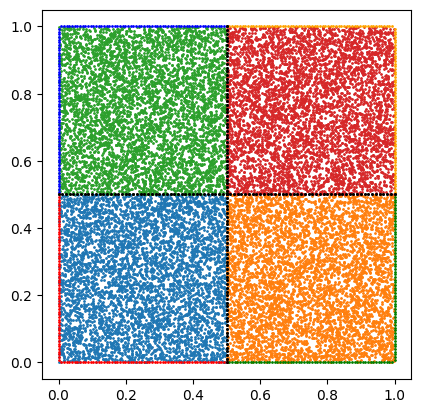

In [15]:
domain = {
        "type"    : "rectangle", 
        "vertices": [(0,0), (0,1), (1,1), (1,0)]
    }
domain_vertex = np.array(domain["vertices"])

boundary_conditions = {
    'left': {'type': 'dirichlet', 'value': 1.0},
    'top': {'type': 'dirichlet', 'value': 1.0},
    'right': {'type': 'dirichlet', 'value': 1.0},
    'bottom': {'type': 'dirichlet', 'value': 0.0},
}
boundary = ['left', 'top', 'right', 'bottom']

csv_file_path = 'data.csv'

random_state = 1
grid_DD = True
Normalizing_input = True
plot_points = True

subdomains = []

if grid_DD:
    nx = 2
    ny = 2
    total_subdomains = nx*ny
else:
    subdomains = [
            # {"type": "rectangle", "vertices": [(-np.pi, -np.pi), (-np.pi, np.pi), (np.pi, np.pi), (np.pi, -np.pi)]}
            {"type": "rectangle", "vertices": [(-np.pi, -np.pi), (-np.pi, 1.5), (-1.5, 1.5), (-1.5, -np.pi)]},
            {"type": "rectangle", "vertices": [(-1.5, -np.pi), (-1.5, -1.5), (np.pi, -1.5), (np.pi, -np.pi)]},
            {"type": "rectangle", "vertices": [(-1.5, -1.5), (-1.5, 1.5), (1.5, 1.5), (1.5, -1.5)]},
            {"type": "rectangle", "vertices": [(1.5, -1.5), (1.5, np.pi), (np.pi, np.pi), (np.pi, -1.5)]},
            {"type": "rectangle", "vertices": [(-np.pi, 1.5), (-np.pi, np.pi), (1.5, np.pi), (1.5, 1.5)]},  
            
            # {"type": "domain", "vertices": [(-np.pi, -np.pi), (-np.pi, np.pi), (np.pi, np.pi), (np.pi, -np.pi)]}
            # {"type": "circle", "center": (0, 0), "radius": 0.5},
            # {"type": "circle", "center": (1.5, 1.5), "radius": 1}
        ]
    total_subdomains = len(subdomains)


# domain_num_points = [[int(1000/total_subdomains)]*total_subdomains, [int(2000/total_subdomains)]*total_subdomains, [int(4000/total_subdomains)]*total_subdomains, [int(5000/total_subdomains)]*total_subdomains, [int(7000/total_subdomains)]*total_subdomains, [int(10000/total_subdomains)]*total_subdomains, [int(15000/total_subdomains)]*total_subdomains, [int(20000/total_subdomains)]*total_subdomains]
domain_num_points = [[int(20000/total_subdomains)]*total_subdomains]
# domain_boundary_points = [100, 200, 300, 400, 500, 600, 700, 800, 900] 
domain_boundary_points = [500]


# subdomain_layer_widths = [[500]*nx*ny, [1000]*nx*ny, [2000]*nx*ny, [3000]*nx*ny, [4000]*nx*ny, [5000]*nx*ny, [6000]*nx*ny]
subdomain_layer_widths = [[int(6400/total_subdomains)]*total_subdomains]

# function = [u_true_gaussian, u_true_sin_2_freq, u_true_polynomial, u_true_decaying_sin, u_true_step_1]
function = [u_true_gaussian]
# function_laplacian = [u_true_laplacian_gaussian, u_true_laplacian_sin_2_freq, u_true_laplacian_polynomial, u_true_laplacian_decaying_sin, u_true_laplacian_step_1]
# function_laplacian = [u_true_laplacian_gaussian]

function_laplacian = [u_laplacian]


domain_points_neighbor_info = generate_points(domain, subdomains, domain_num_points[0], domain_boundary_points[0], grid_DD, Normalizing_input, True, random_state, nx=nx, ny=ny)


Internal points from each subdomain:  [5000, 5000, 5000, 5000]
{0: [1, 2], 1: [0, 3], 2: [0, 3], 3: [1, 2]}
[1600, 1600, 1600, 1600]
### Model initialized using SWIM ###
### Matrix_in created of shape:  (21052, 6404)  ###
### Matrix_out created of shape:  (21052, 1)  ###
### Solving linear system of equations ###
### Solving completed ###
time for solving 151.17987608909607 seconds.
Maximum error:  [1.0370221]


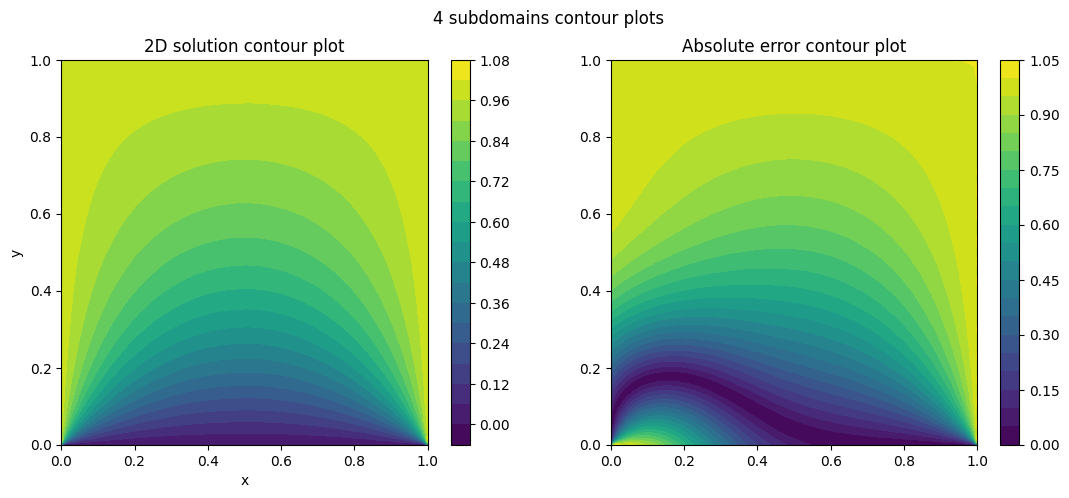

In [16]:
with open(csv_file_path, mode='a', newline='') as file:
    writer = csv.writer(file)

    for f in range(len(function)):
        for n in range(len(domain_num_points)):
            for l in range(len(subdomain_layer_widths)):
                for b in range(len(domain_boundary_points)):
                    subdomains = []
                    # print(domain_num_points[n])
                    domain_points_neighbor_info = generate_points(domain, subdomains, domain_num_points[n], domain_boundary_points[b], grid_DD, Normalizing_input, False, random_state, nx=nx, ny=ny)
                    subdomains = domain_points_neighbor_info[0]
                    internal_points_subdomain = domain_points_neighbor_info[1]
                    boundary_points_subdomain = domain_points_neighbor_info[2]
                    shared_points_subdomain = domain_points_neighbor_info[3]
                    neighbor_list = domain_points_neighbor_info[4]
                    x_center = domain_points_neighbor_info[5]
                    y_center = domain_points_neighbor_info[6]
                    x_radius = domain_points_neighbor_info[7]
                    y_radius = domain_points_neighbor_info[8]


                    u_laplacian_train = []
                    u_true_train = []
                    u_boundary = []
                    u_boundary_train = []

                    for i in range(len(subdomains)):
                        u_laplacian_train.append(function_laplacian[f](internal_points_subdomain[i]).reshape((-1,1)))
                        u_true_train.append(function[f](internal_points_subdomain[i]).reshape((-1,1)))
                        u_boundary = []
                        if not boundary_points_subdomain[i] is None: 
                            for j,element in enumerate(boundary_points_subdomain[i]):
                                if element is not None:
                                    b_value = boundary_conditions[boundary[j]]['value']
                                    u_boundary.append(np.ones((element.shape[0],1))*b_value)
                                    # u_boundary.append(function[f](element).reshape((-1,1)))
                                else:
                                    u_boundary.append(np.empty((0,1)))
                        else:
                            u_boundary.append(np.empty((0,1)))
                        u_boundary_train.append(u_boundary)

                    for i in range(len(subdomains)):
                        internal_points_subdomain[i][:,0] = (internal_points_subdomain[i][:,0]-(x_center[i]))/(x_radius[i])
                        internal_points_subdomain[i][:,1] = (internal_points_subdomain[i][:,1]-(y_center[i]))/(y_radius[i])           

                    # print(internal_points_subdomain)
                    for i in range(len(subdomains)):
                        if not boundary_points_subdomain[i] is None:
                            for j,element in enumerate(boundary_points_subdomain[i]):
                                if element is not None:
                                    boundary_points_subdomain[i][j][:,0] = (boundary_points_subdomain[i][j][:,0]-(x_center[i]))/(x_radius[i])
                                    boundary_points_subdomain[i][j][:,1] = (boundary_points_subdomain[i][j][:,1]-(y_center[i]))/(y_radius[i])

                    for i in range(len(shared_points_subdomain)):
                        for j in range(len(shared_points_subdomain[i])):
                            shared_points_subdomain[i][j][:,0] = (shared_points_subdomain[i][j][:,0]-(x_center[i]))/(x_radius[i])
                            shared_points_subdomain[i][j][:,1] = (shared_points_subdomain[i][j][:,1]-(y_center[i]))/(y_radius[i])

                    t0 = time()
                    model = solve_swim_PINN(internal_points_subdomain, boundary_points_subdomain, shared_points_subdomain, subdomains, u_true_train, u_laplacian_train, u_boundary_train, subdomain_layer_widths[l], neighbor_list, x_center, y_center, x_radius, y_radius, random_state=1)
                    print("time for solving", time()-t0, "seconds.")

                    n_pts_train = 150
                    x_lin = np.linspace(domain_vertex[0][0], domain_vertex[2][0], n_pts_train)
                    y_lin = np.linspace(domain_vertex[0][1], domain_vertex[2][1], n_pts_train)
                    x_t, y_t = np.meshgrid(x_lin, y_lin)
                    # x = np.sort(rng.uniform(lims[0], lims[1], size=(n_pts_train, 1)), axis = 0)
                    # y = np.sort(rng.uniform(lims[0], lims[1], size=(n_pts_train, 1)), axis = 0)
                    # x_t, y_t = np.meshgrid(x, y)

                    # solution_1 = np.zeros_like(x_t)
                    solution = model(np.column_stack([x_t.reshape(-1,1), y_t.reshape(-1,1)]))

                    error = np.absolute(function[f](np.column_stack([x_t.reshape(-1,1), y_t.reshape(-1,1)])).reshape(-1,1) - solution)
                    # error = function[f](np.column_stack([x_t.reshape(-1,1), y_t.reshape(-1,1)])).reshape(-1,1)
                    max_error = np.max(error)
                    mean_error = np.mean(error)
                    print("Maximum error: ",max(error))
                    error = error.reshape(n_pts_train, n_pts_train)

                    solution = solution.reshape(n_pts_train, n_pts_train)

                    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
                    contour1 = ax[0].contourf(x_t, y_t, solution, levels=20, cmap='viridis')
                    contour2 = ax[1].contourf(x_t, y_t, error, levels=20, cmap = 'viridis') 

                    colorbar = plt.colorbar(contour1, ax=ax[0])
                    colorbar = plt.colorbar(contour2, ax=ax[1])

                    plt.suptitle(f'{len(subdomains)} subdomains contour plots')
                    ax[0].set_title('2D solution contour plot')
                    ax[1].set_title('Absolute error contour plot')
                    ax[0].set_xlabel('x')
                    ax[0].set_ylabel('y')

        #             data = [domain_num_points[n], domain_boundary_points[b], subdomain_layer_widths[l], max_error, mean_error]
                    
        #             writer.writerow(data)
        # writer.writerow([])



Thesis outline:

- Background theory   
    - Background and related work (Description about methods used to solve pdes using neural network)  
    - Problems associated with conventional methods (Meshing around complex geometries)
    
- Introduction    
    - Short description about the components used to generate solution of the pde or write a short para on the sections in the thesis.  

- Implementation description
    - Sections about different components in the paper for eg: Neural network architecture, Domain decomposition and points sampling, pde conditions (Internal and boundary), constructing the input and output matrices, solving (compare solvers maybe?)  
    -Neural Network 
        - Neural network architecture
        - input and output layers
        - activation function
        - sampling techniques of weights and biases 
    -Domain decomposition and points sampling
        - Description about domain decomposition 2 types implemented (Grid and arbitrary)
        - Points sampled: 1. Internal points, 2. Boundary points, 3. Shared points for each subdomain
    -pde conditions and boundary conditions
        - Equations for internal points and boundary points from neural network output
        - Additional equations for shared points
        - Construction of coefficient matrix and RHS vector
    -solution procedure (Least squares)
    -**Final algorithm to generate solution of pde** 

- Comparison Study ? (Appendix)
    - Comparison study on the effect of changing layer width, internal points sampled and boundary points sampled on the solution accuracy.  

- Problem description and Results or Results as a separate section
    - 1d, 2d problems
    - Each problem gets its section **decide on the problems to solve**  
      
- Results

- Conclusion

- Appendix
    - Experiments 

